In [1]:
pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install scorecardpy

In [3]:
# 1. Core Libraries
import numpy as np
import pandas as pd

# 2. Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# 3. Statistics & Optimization
from scipy import stats
from scipy.optimize import fsolve
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 4. Machine Learning (Scikit-learn)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay
)

# 5. XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

# 6. Deep Learning (Keras)
from keras import models, layers

# 7. Scorecard & Credit Modeling
import scorecardpy as sc

# 8. Jupyter Notebook 
%matplotlib inline  


In [4]:
# ----------------------------
# STEP 1: Data Preparation
# ----------------------------

# Read the 'credit_score.csv' file into a pandas DataFrame, treating specified values as missing values (NaN)
df_raw = pd.read_csv('credit_score.csv', na_values=["NA", "N/A", "None", "null", " "])

# Display the first 5 rows of the DataFrame to get an overview of the data
df_raw.head()  # Check the top rows to understand the structure and presence of missing values


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents
0,0,0.213179,74,0,0.375607,3500,3,0,1,0,1
1,0,0.452516,24,0,0.011761,3400,1,0,0,0,0
2,0,0.368876,68,0,1687.500000,1,31,0,1,0,0
3,0,0.029164,31,0,0.395032,3300,10,0,1,0,0
4,0,0.317976,34,0,0.297934,4500,11,0,2,0,0


In [5]:
# ----------------------------
# STEP 2: Rename Columns to Simpler Names
# ----------------------------

# Rename the columns to simpler 
df_raw = df_raw.rename(columns={
    'SeriousDlqin2yrs': 'Delinquent', # Borrower experienced 90 days past due delinquency or worse
    'RevolvingUtilizationOfUnsecuredLines': 'RevolvingUtil', # Total balance on credit cards and personal lines of credit (except real estate and no instalment debt like car loans) divided by the sum of credit limits
    'age': 'Age',
    'NumberOfTime30_59DaysPastDueNotWorse': 'PastDue30_59', # Number of times borrower has been 30-59 days past due but no worse in the last 2 years
    'DebtRatio': 'DebtRatio', # Monthly debt payments, alimony, living costs divided by monthly gross income
    'MonthlyIncome': 'Income',
    'NumberOfOpenCreditLinesAndLoans': 'OpenCreditLines', # Number of open loans (instalment like car loan or mortgage) and lines of credit (e.g. credit cards)
    'NumberOfTimes90DaysLate': 'PastDue90', # Number of times borrower has been 90 days or more past due
    'NumberRealEstateLoansOrLines': 'RealEstateLoans', # Number of mortgage and real estate loans including home equity lines of credit
    'NumberOfTime60_89DaysPastDueNotWorse': 'PastDue60_89', # Number of times borrower has been 60-89 days past due but no worse in the last 2 years
    'NumberOfDependents': 'Dependents' # Number of dependents in family excluding themselves (spouse, children, etc.)
})

# Display new column names and general information about the DataFrame
print(df_raw.columns)  # Check new column names
df_raw.info()          # Display summary of DataFrame info (data types, non-null count)


Index(['Delinquent', 'RevolvingUtil', 'Age', 'PastDue30_59', 'DebtRatio',
       'Income', 'OpenCreditLines', 'PastDue90', 'RealEstateLoans',
       'PastDue60_89', 'Dependents'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3475 entries, 0 to 3474
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Delinquent       3475 non-null   int64  
 1   RevolvingUtil    3475 non-null   float64
 2   Age              3475 non-null   int64  
 3   PastDue30_59     3475 non-null   int64  
 4   DebtRatio        3475 non-null   float64
 5   Income           3475 non-null   int64  
 6   OpenCreditLines  3475 non-null   int64  
 7   PastDue90        3475 non-null   int64  
 8   RealEstateLoans  3475 non-null   int64  
 9   PastDue60_89     3475 non-null   int64  
 10  Dependents       3475 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 298.8 KB


In [6]:
# ----------------------------
# STEP 3: Check for Missing Values
# ----------------------------

# Check for missing values in the entire DataFrame
print(df_raw.isnull().sum())  # Display count of missing values for each column


Delinquent         0
RevolvingUtil      0
Age                0
PastDue30_59       0
DebtRatio          0
Income             0
OpenCreditLines    0
PastDue90          0
RealEstateLoans    0
PastDue60_89       0
Dependents         0
dtype: int64


In [7]:
# ----------------------------
# STEP 4: Summary Statistics
# ----------------------------

# Generate summary statistics of the DataFrame
df_raw.describe()  # Provides summary statistics for numerical columns


,Delinquent,RevolvingUtil,Age,PastDue30_59,DebtRatio,Income,OpenCreditLines,PastDue90,RealEstateLoans,PastDue60_89,Dependents
count,3475.000000,3475.000000,3475.000000,3475.000000,3475.000000,3475.000000,3475.000000,3475.000000,3475.000000,3475.000000,3475.000000
mean,0.069640,1.904751,51.334676,0.348201,24.455380,6702.922014,8.759424,0.168921,1.065324,0.141871,0.834532
std,0.254576,91.990059,14.591973,2.960918,294.359660,13689.391579,5.218068,2.914333,1.117734,2.890889,1.142402
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.035638,40.000000,0.000000,0.145500,3309.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.180455,51.000000,0.000000,0.299058,5316.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.580334,62.000000,0.000000,0.487463,8300.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,5423.000000,102.000000,98.000000,12018.000000,730483.000000,43.000000,98.000000,13.000000,98.000000,8.000000


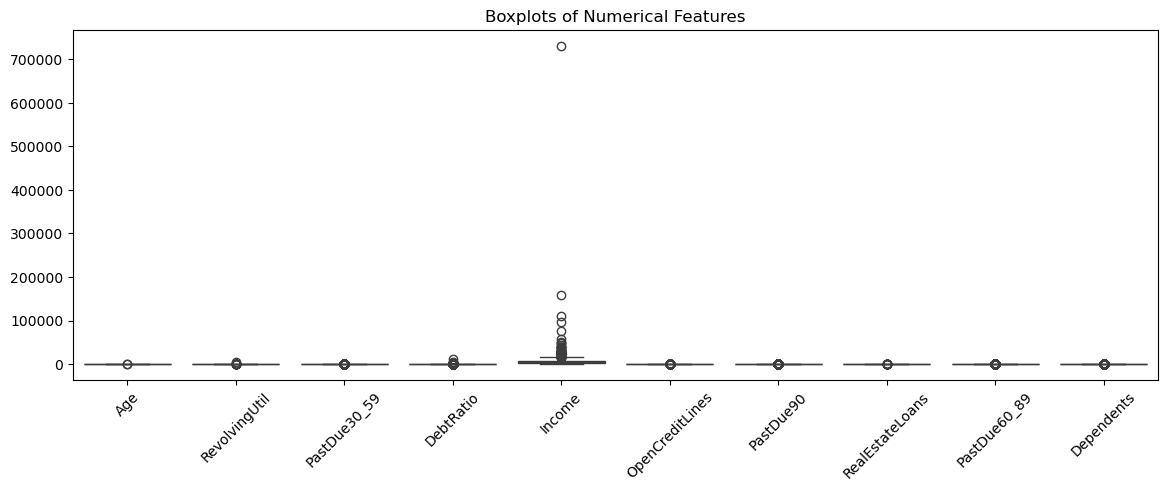

In [8]:
# ----------------------------
# STEP 5: Outlier Detection - Boxplots
# ----------------------------

# Set the overall figure size
plt.figure(figsize=(14, 10))

# 1. Boxplots for numerical columns to check for outliers
plt.subplot(2, 1, 1)  # Changed to 2 rows, 1 column
sns.boxplot(data=df_raw[['Age', 
                         'RevolvingUtil', 
                         'PastDue30_59', 
                         'DebtRatio', 
                         'Income', 
                         'OpenCreditLines', 
                         'PastDue90', 
                         'RealEstateLoans', 
                         'PastDue60_89', 
                         'Dependents']])
plt.title("Boxplots of Numerical Features")
plt.xticks(rotation=45)
plt.show()


In [9]:
# ----------------------------
# STEP 6: Outlier Detection and Removal Using Z-Score
# ----------------------------

# --- Function to detect outliers using Z-Score ---
def detect_outliers_zscore(df_raw, column, threshold=3):
    mean = df_raw[column].mean()
    std = df_raw[column].std()
    z_scores = (df_raw[column] - mean) / std
    outliers = df_raw[(np.abs(z_scores) > threshold)]  # Identify outliers based on Z-score threshold
    return outliers

# --- Function to remove outliers using Z-Score ---
def remove_outliers_zscore(df_raw, columns, threshold=3):
    for col in columns:
        # Skip 'PastDue' columns, replace outliers with mean
        if col in ['PastDue30_59', 'PastDue60_89', 'PastDue90', 'OpenCreditLines']:
            mean_value = df_raw[col].mean()
            df_raw[col] = np.where(np.abs((df_raw[col] - df_raw[col].mean()) / df_raw[col].std()) > threshold, mean_value, df_raw[col])
        else:
            mean = df_raw[col].mean()
            std = df_raw[col].std()
            z_scores = (df_raw[col] - mean) / std
            df_raw = df_raw[(np.abs(z_scores) <= threshold)]  # Keep rows where z-score <= threshold
    return df_raw

# --- list of columns ---
variables = ['Age', 
             'RevolvingUtil', 
             'PastDue30_59', 
             'DebtRatio', 
             'Income', 
             'OpenCreditLines', 
             'PastDue90', 
             'RealEstateLoans', 
             'PastDue60_89', 
             'Dependents']

# --- Save original shape ---
print("Shape before outlier removal:", df_raw.shape)

# --- Detect outliers before removal ---
for col in variables:
    outliers = detect_outliers_zscore(df_raw, col)
    print(f"{col}: {len(outliers)} outliers detected")

# --- Remove outliers and handle PastDue columns differently ---
df = remove_outliers_zscore(df_raw.copy(), variables)

# --- Print shapes ---
print("Shape after outlier removal and mean replacement for PastDue columns:", df.shape)


Shape before outlier removal: (3475, 11)
Age: 2 outliers detected
RevolvingUtil: 1 outliers detected
PastDue30_59: 3 outliers detected
DebtRatio: 30 outliers detected
Income: 9 outliers detected
OpenCreditLines: 43 outliers detected
PastDue90: 4 outliers detected
RealEstateLoans: 35 outliers detected
PastDue60_89: 3 outliers detected
Dependents: 25 outliers detected
Shape after outlier removal and mean replacement for PastDue columns: (3377, 11)


In [10]:
# ----------------------------
# STEP 7: Check Summary Statistics After Removing Outliers
# ----------------------------

# Display the summary statistics after removing outliers
df.describe()


,Delinquent,RevolvingUtil,Age,PastDue30_59,DebtRatio,Income,OpenCreditLines,PastDue90,RealEstateLoans,PastDue60_89,Dependents
count,3377.000000,3377.000000,3377.000000,3377.000000,3377.000000,3377.000000,3377.000000,3377.000000,3377.000000,3377.000000,3377.000000
mean,0.068108,0.344253,51.349719,0.262376,2.844095,6311.646728,8.423857,0.078970,1.002369,0.058464,0.801895
std,0.251968,0.498213,14.641308,0.723850,37.391128,4477.929919,4.648831,0.392863,0.970229,0.286712,1.075424
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.035009,40.000000,0.000000,0.141746,3333.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.177986,51.000000,0.000000,0.293122,5300.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.578605,62.000000,0.000000,0.474947,8166.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,14.127182,93.000000,9.000000,853.000000,47900.000000,24.000000,7.000000,4.000000,4.000000,4.000000


In [11]:
# ----------------------------
# STEP 8: Set Correct Data Types
# ----------------------------

# Set the correct data types for each column
df = df.astype({
    'Delinquent': 'int',
    'RevolvingUtil': 'float',
    'Age': 'int',
    'PastDue30_59': 'int',
    'DebtRatio': 'float',
    'Income': 'int',
    'OpenCreditLines': 'int',
    'PastDue90': 'int',
    'RealEstateLoans': 'int',
    'PastDue60_89': 'int',
    'Dependents': 'int'   
})

# Check the updated data types
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3377 entries, 0 to 3474
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Delinquent       3377 non-null   int64  
 1   RevolvingUtil    3377 non-null   float64
 2   Age              3377 non-null   int64  
 3   PastDue30_59     3377 non-null   int64  
 4   DebtRatio        3377 non-null   float64
 5   Income           3377 non-null   int64  
 6   OpenCreditLines  3377 non-null   int64  
 7   PastDue90        3377 non-null   int64  
 8   RealEstateLoans  3377 non-null   int64  
 9   PastDue60_89     3377 non-null   int64  
 10  Dependents       3377 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 316.6 KB


In [12]:
# ----------------------------
# STEP 9: Split Train-Test Set
# ----------------------------

# Make sure 'Delinquent' is still in the dataframe
train_test = sc.split_df(df, y='Delinquent', ratio=0.7, seed=33245215)

# Unpack train and test sets
train_ori = train_test['train']
test_ori = train_test['test']


In [13]:
# Display summary statistics for the training dataset (train_ori)
train_ori.describe() 

,Delinquent,RevolvingUtil,Age,PastDue30_59,DebtRatio,Income,OpenCreditLines,PastDue90,RealEstateLoans,PastDue60_89,Dependents
count,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000
mean,0.068105,0.346979,51.410745,0.250000,3.054435,6395.297377,8.435702,0.076565,1.000846,0.062183,0.813452
std,0.251979,0.545432,14.549755,0.683909,38.058792,4622.914370,4.702636,0.367502,0.983141,0.298011,1.076572
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.034924,40.000000,0.000000,0.140763,3314.500000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.174662,51.000000,0.000000,0.295014,5295.500000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.583269,62.000000,0.000000,0.472713,8333.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,14.127182,93.000000,6.000000,853.000000,47900.000000,24.000000,5.000000,4.000000,4.000000,4.000000


[INFO] creating woe binning ...


/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass o

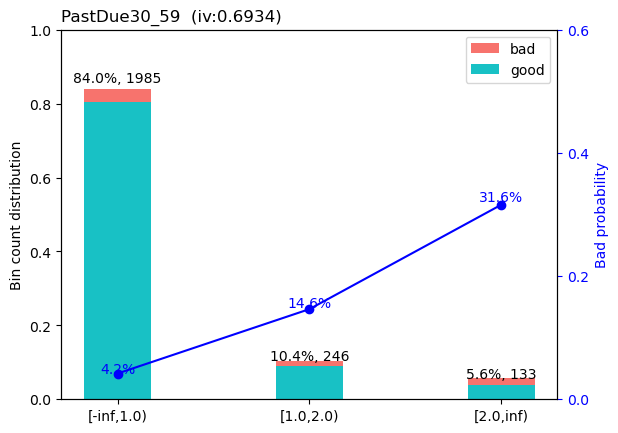

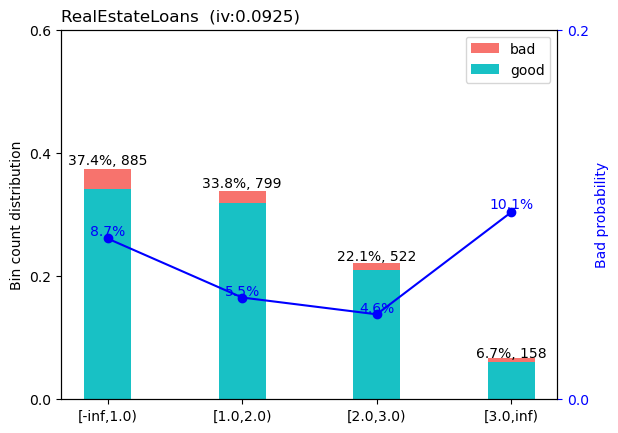

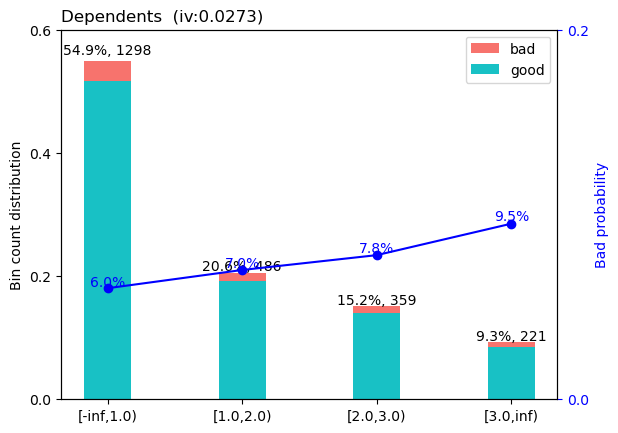

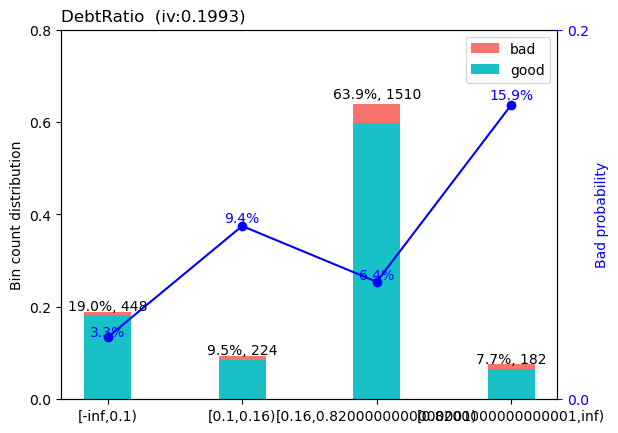

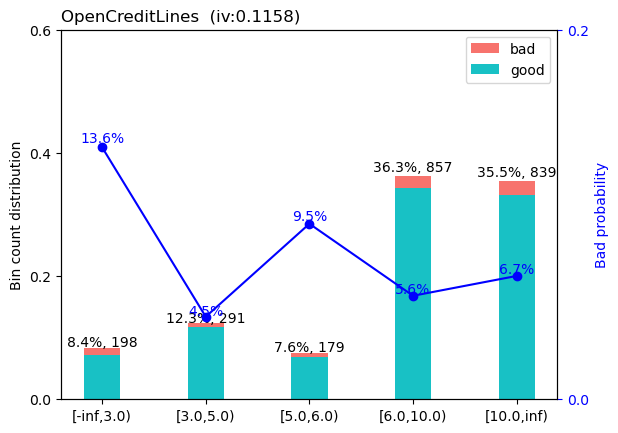

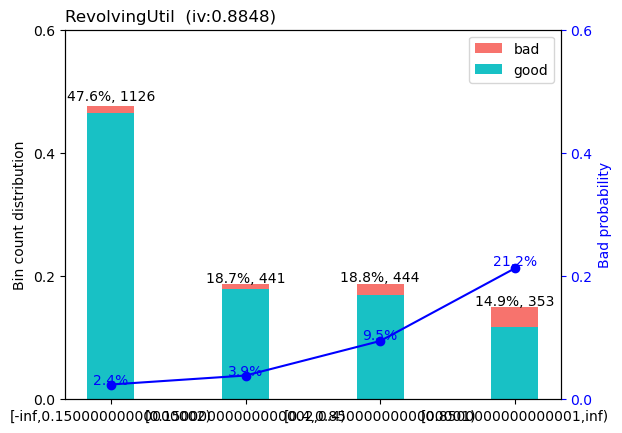

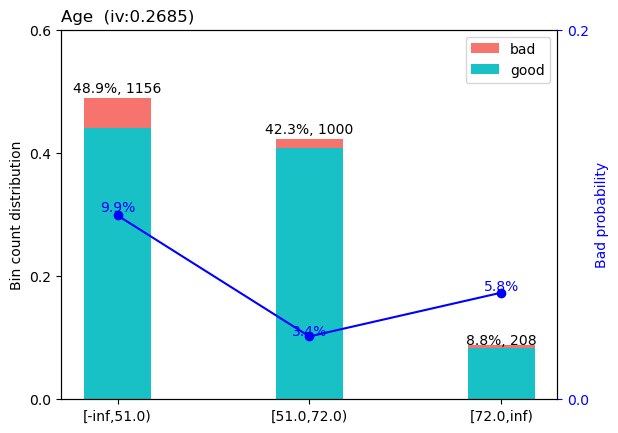

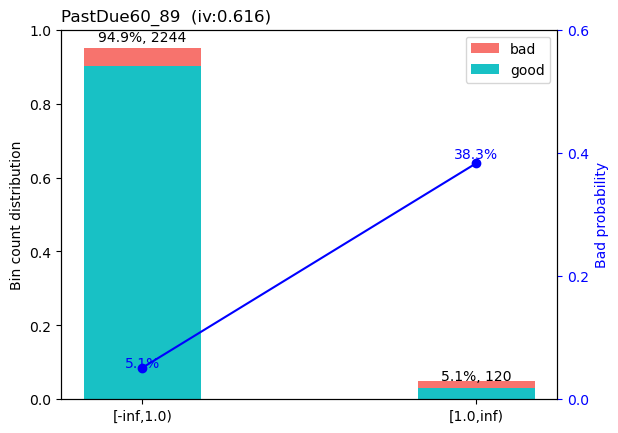

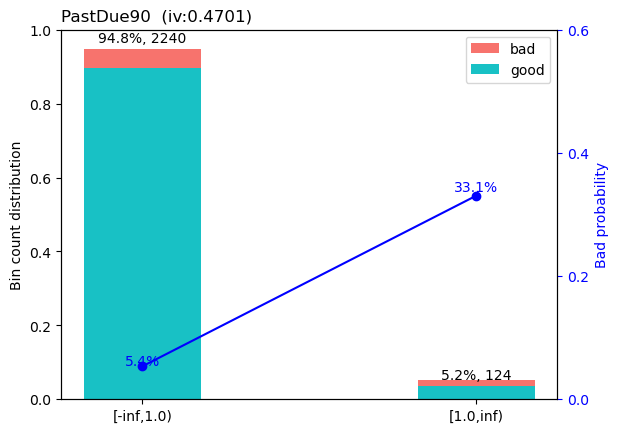

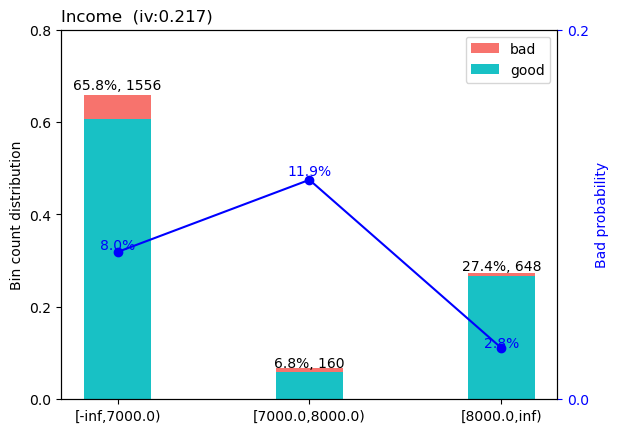

In [14]:
# ----------------------------
# 1: Logistic Regression Model with WOE Start
# ----------------------------

# ----------------------------
# STEP 1: BINNING
# ----------------------------

# The parameters include:
# - 'positive=1' indicates that the positive class for the target is '1' (delinquent borrowers).
# - 'min_perc_fine_bin=0.02' ensures that fine bins have at least 2% of the data.
# - 'min_perc_coarse_bin=0.05' ensures that coarse bins have at least 5% of the data.
# - 'stop_limit=0.1' defines the stop criterion when the improvement in the binning process is less than 0.1.
# - 'max_num_bin=8' limits the maximum number of bins to 8 for better interpretability.
# - 'method='tree'' specifies that a tree-based method is used for binning.

# Perform the binning
bins = sc.woebin(train_ori, y='Delinquent', positive=1,   
                 min_perc_fine_bin=0.02,                
                 min_perc_coarse_bin=0.05,             
                 stop_limit=0.1,                       
                 max_num_bin=8,                        
                 method='tree')

# Visualize the binning results to inspect the distribution and relationship of features with the target variable
sc.woebin_plot(bins)  # Plot the WoE binning
plt.show()            # Display the plot


In [15]:
# ----------------------------
# STEP 2: TRAIN TEST SET WOE
# ----------------------------

# Apply WoE transformation to the training dataset
train_woe = sc.woebin_ply(train_ori, bins)  # Transform the train set using WoE bins

# Apply WoE transformation to the testing dataset
test_woe = sc.woebin_ply(test_ori, bins)   # Transform the test set using WoE bins


[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [16]:
# ----------------------------
# STEP 3: FILTERING BASED ON IV (Information Value)
# ----------------------------

# The general interpretation of IV values is as follows:
# - IV < 0.02: No predictive ability, consider removing.
# - 0.02 ≤ IV < 0.1: Small predictive ability, suggest to remove.
# - 0.1 ≤ IV < 0.3: Medium predictive ability, leave.
# - 0.3 ≤ IV < 1: Good predictive ability, leave.
# - IV ≥ 1: Strong predictive ability. If a feature has an IV > 1, 
#   investigate for potential errors in calculation (e.g., WoE leaving a category 
#   with 100% goods or bads) or it could be capturing future information.

# Calculate Information Value (IV) for the transformed training dataset
sc.iv(train_woe, 'Delinquent')


,variable,info_value
0,RevolvingUtil_woe,0.884780
3,PastDue30_59_woe,0.693380
9,PastDue60_89_woe,0.615951
2,PastDue90_woe,0.470073
1,Age_woe,0.268520
7,Income_woe,0.217007
6,DebtRatio_woe,0.199314
8,OpenCreditLines_woe,0.115846
4,RealEstateLoans_woe,0.092479
5,Dependents_woe,0.027272


In [17]:
# Check column order.
train_woe.columns


Index(['Delinquent', 'PastDue30_59_woe', 'RealEstateLoans_woe',
       'Dependents_woe', 'DebtRatio_woe', 'OpenCreditLines_woe',
       'RevolvingUtil_woe', 'Age_woe', 'PastDue60_89_woe', 'PastDue90_woe',
       'Income_woe'],
      dtype='object')

In [18]:
# ----------------------------
# STEP 4: FILTERING VARIABLES BASED ON IV
# ----------------------------

# Drop 'RealEstateLoans_woe' and 'Dependents_woe' from both the training and testing datasets
train_woe = train_woe.drop(['RealEstateLoans_woe', 'Dependents_woe'], axis=1)
test_woe = test_woe.drop(['RealEstateLoans_woe', 'Dependents_woe'], axis=1)


In [19]:
# Display the first few rows of the test dataset after WoE transformation and filtering
test_woe.head()  # Shows the transformed test dataset, where low IV variables have been removed


,Delinquent,PastDue30_59_woe,DebtRatio_woe,OpenCreditLines_woe,RevolvingUtil_woe,Age_woe,PastDue60_89_woe,PastDue90_woe,Income_woe
3,0,-0.515650,-0.073659,-0.021610,-1.090148,0.413166,-0.302305,-0.255509,0.169625
8,0,-0.515650,-0.073659,-0.208427,-1.090148,-0.730632,-0.302305,-0.255509,0.169625
9,0,-0.515650,-0.073659,-0.021610,-1.090148,-0.730632,-0.302305,-0.255509,0.169625
11,0,-0.515650,-0.073659,-0.208427,-1.090148,0.413166,-0.302305,-0.255509,0.169625
15,0,1.842981,-0.073659,-0.446501,-1.090148,0.413166,-0.302305,-0.255509,-0.939177


In [20]:
# ----------------------------
# STEP 5: Model Setup
# ----------------------------

# Initialize the Logistic Regression model with specific parameters
Delinquent_logreg = LogisticRegression(
    penalty='l2',                # Type of penalization (l2 = ridge)
    tol=0.0001,                  # Tolerance for stopping criteria
    C=1.0,                       # Regularization strength, the smaller the stronger
    fit_intercept=True,          # Include the intercept (constant term)
    class_weight='balanced',     # Adjust class weights for imbalanced data
    random_state=33245215,       # Seed for reproducibility
    max_iter=500,                # Maximum number of iterations for convergence
    verbose=1,                   # Display training process
    solver='sag',                # Solver algorithm for optimization (Stochastic Average Gradient)
    warm_start=False             # Train from scratch (not reusing previous model)
)


In [21]:
# ----------------------------
# STEP 6: Train Logistic Regression Model
# ----------------------------

# Fit the Logistic Regression model on the training data (train_woe)
Delinquent_logreg.fit(
    X=train_woe.iloc[:, 1:],      # Use all rows and columns starting from the second variable to the end (features)
    y=train_woe['Delinquent']     # The target variable 'Delinquent' (binary outcome)
)


max_iter reached after 0 seconds


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=500, random_state=33245215,
                   solver='sag', verbose=1)

In [22]:
# ----------------------------
# STEP 7: Coefficients of Logistic Regression
# ----------------------------

# Extract and display the coefficients of the Logistic Regression model
# Create a DataFrame with the feature names and their corresponding coefficients
coef_df = pd.concat([
    pd.DataFrame({'column': train_woe.columns[1:]}),    # Feature names (excluding the target column)
    pd.DataFrame(np.transpose(Delinquent_logreg.coef_)) # Model coefficients for each feature
], axis=1)

# Display the DataFrame containing the features and their corresponding coefficients
coef_df


,column,0
0,PastDue30_59_woe,0.877515
1,DebtRatio_woe,1.299301
2,OpenCreditLines_woe,0.650201
3,RevolvingUtil_woe,0.541248
4,Age_woe,0.683533
5,PastDue60_89_woe,0.863486
6,PastDue90_woe,0.529725
7,Income_woe,0.428300


In [23]:
# Display the first few rows of the test set after applying the WoE transformation
# This allows us to check the format and the features after binning and WoE encoding
test_woe.head()

,Delinquent,PastDue30_59_woe,DebtRatio_woe,OpenCreditLines_woe,RevolvingUtil_woe,Age_woe,PastDue60_89_woe,PastDue90_woe,Income_woe
3,0,-0.515650,-0.073659,-0.021610,-1.090148,0.413166,-0.302305,-0.255509,0.169625
8,0,-0.515650,-0.073659,-0.208427,-1.090148,-0.730632,-0.302305,-0.255509,0.169625
9,0,-0.515650,-0.073659,-0.021610,-1.090148,-0.730632,-0.302305,-0.255509,0.169625
11,0,-0.515650,-0.073659,-0.208427,-1.090148,0.413166,-0.302305,-0.255509,0.169625
15,0,1.842981,-0.073659,-0.446501,-1.090148,0.413166,-0.302305,-0.255509,-0.939177


In [24]:
# ----------------------------
# Step 8: Apply Model to Test Set and Predict
# ----------------------------

# Predict the class labels (0 or 1) for the test set using the logistic regression model
# 'pred_class_test' contains the predicted class labels
pred_class_test = Delinquent_logreg.predict(test_woe.iloc[:, 1:])

# Predict the probability estimates for the test set
# 'probs_test' contains the predicted probabilities for each class
probs_test = Delinquent_logreg.predict_proba(test_woe.iloc[:, 1:])

# Print predicted probabilities and class labels for the test set
# The output shows the predicted probabilities for each class and the final predicted class labels
print(probs_test, pred_class_test)


[[0.75091711 0.24908289]
 [0.88150934 0.11849066]
 [0.86822249 0.13177751]
 ...
 [0.72253842 0.27746158]
 [0.91374415 0.08625585]
 [0.610454   0.389546  ]] [0 0 0 ... 0 0 0]


In [25]:
# ----------------------------
# STEP 9: Generate the Scorecard
# ----------------------------

# Get feature columns (excluding target)
xcolumns = train_woe.columns[1:]

# Generate scorecard using trained model and bins
scorecard = sc.scorecard(bins, Delinquent_logreg, xcolumns=xcolumns)

# Combine all variable scorecards into a single DataFrame
scorecard_df = pd.concat(scorecard.values(), axis=0).reset_index(drop=True)

# Rename for clarity
scorecard_df.rename(columns={
    'variable': 'Feature',
    'bin': 'Bin',
    'points': 'Score'
}, inplace=True)

# Optional: Round scores
scorecard_df['Score'] = scorecard_df['Score'].round(1)

# Display final scorecard
print(scorecard_df)


            Feature                         Bin  Score
0        basepoints                         NaN  381.0
1      PastDue30_59                  [-inf,1.0)   33.0
2      PastDue30_59                   [1.0,2.0)  -54.0
3      PastDue30_59                   [2.0,inf) -117.0
4         DebtRatio                  [-inf,0.1)   70.0
5         DebtRatio                  [0.1,0.16)  -33.0
6         DebtRatio   [0.16,0.8200000000000001)    7.0
7         DebtRatio    [0.8200000000000001,inf)  -89.0
8   OpenCreditLines                  [-inf,3.0)  -36.0
9   OpenCreditLines                   [3.0,5.0)   21.0
10  OpenCreditLines                   [5.0,6.0)  -17.0
11  OpenCreditLines                  [6.0,10.0)   10.0
12  OpenCreditLines                  [10.0,inf)    1.0
13    RevolvingUtil  [-inf,0.15000000000000002)   43.0
14    RevolvingUtil   [0.15000000000000002,0.4)   23.0
15    RevolvingUtil    [0.4,0.8500000000000001)  -14.0
16    RevolvingUtil    [0.8500000000000001,inf)  -51.0
17        

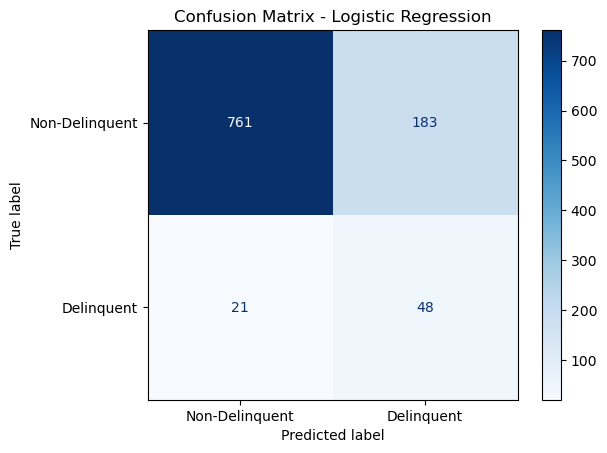

ROC AUC Score: 0.8500


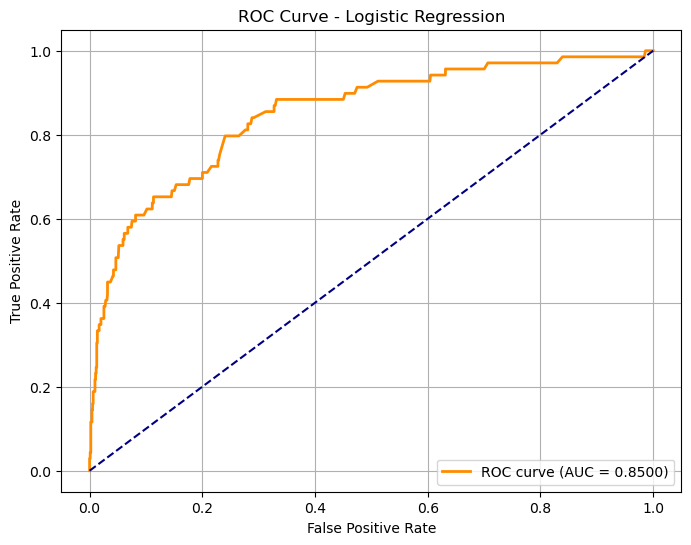

Classification Report_LG:
                 precision    recall  f1-score   support

Non-Delinquent       0.97      0.81      0.88       944
    Delinquent       0.21      0.70      0.32        69

      accuracy                           0.80      1013
     macro avg       0.59      0.75      0.60      1013
  weighted avg       0.92      0.80      0.84      1013



In [26]:
# ----------------------------
# STEP 10: Model Evaluation
# ----------------------------

# ----------------------------
# 1. Confusion Matrix
# ----------------------------
cm = confusion_matrix(test_woe['Delinquent'], pred_class_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Delinquent", "Delinquent"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ----------------------------
# 2. ROC AUC Score
# ----------------------------
# Use the probability of the positive class (index 1)
roc_auc = roc_auc_score(test_woe['Delinquent'], probs_test[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

# ----------------------------
# 3. ROC Curve
# ----------------------------
fpr, tpr, thresholds = roc_curve(test_woe['Delinquent'], probs_test[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ----------------------------
# 4. Classification Report
# ----------------------------
report = classification_report(test_woe['Delinquent'], pred_class_test, target_names=["Non-Delinquent", "Delinquent"])
print("Classification Report_LG:\n", report)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


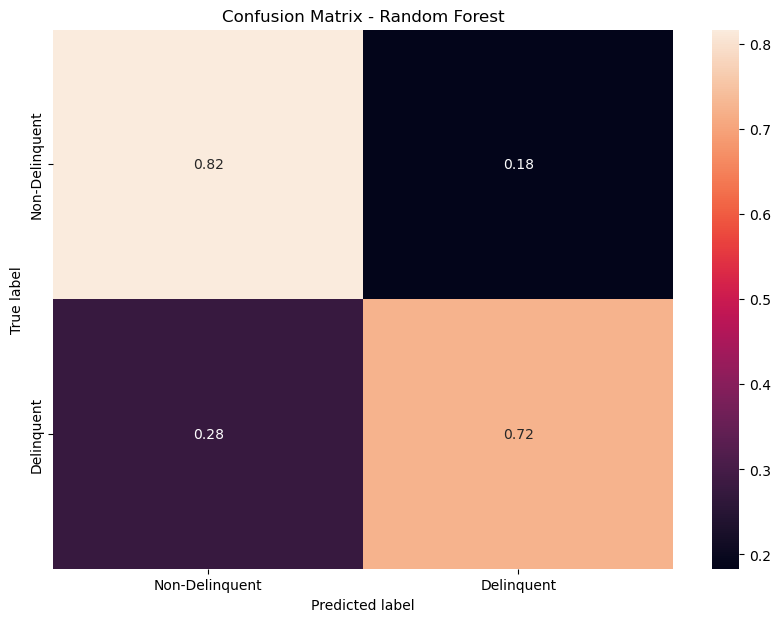

ROC AUC Score: 0.8569


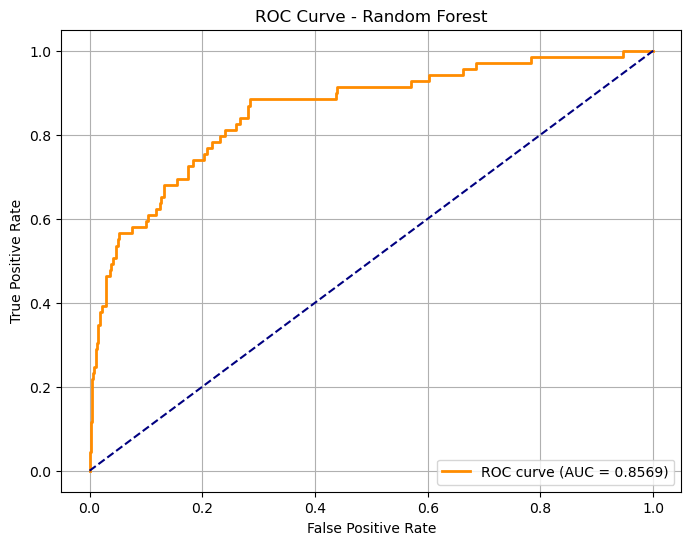

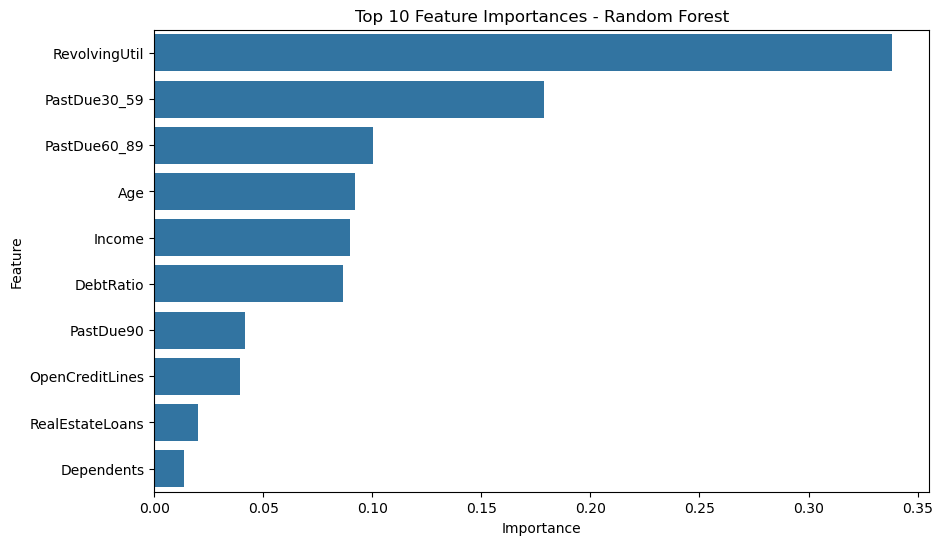


Classification Report RF:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89       944
           1       0.22      0.72      0.34        69

    accuracy                           0.81      1013
   macro avg       0.60      0.77      0.62      1013
weighted avg       0.92      0.81      0.85      1013



In [27]:
# ----------------------------
# 2: Random Forest Model with ORI Start
# ----------------------------

# ----------------------------
# STEP 1: Data Preparation
# ----------------------------

# Split training and testing datasets into features (X) and target (y)
X_train_rf = train_ori.drop(columns='Delinquent')  # Features for training
y_train_rf = train_ori['Delinquent']               # Target for training

X_test_rf = test_ori.drop(columns='Delinquent')    # Features for testing
y_test_rf = test_ori['Delinquent']                 # Target for testing

# ----------------------------
# STEP 2: Model Training
# ----------------------------

# Initialize the Random Forest Classifier with selected hyperparameters
Delinquent_rf = RandomForestClassifier(
    n_estimators=200,               # Number of trees in the forest
    criterion='gini',               # Splitting criterion
    max_depth=6,                    # Maximum depth of each tree
    min_samples_split=20,          # Minimum samples to split a node
    min_samples_leaf=0.01,         # Minimum samples at a leaf node (fraction)
    max_features='log2',           # Max features considered at each split
    bootstrap=True,                # Enable bootstrap samples
    oob_score=True,                # Use OOB samples for accuracy
    n_jobs=-1,                     # Use all processors
    random_state=33245215,         # For reproducibility
    class_weight='balanced',       # Handle imbalanced classes
    verbose=1                      # Print training progress
)

# Train the model on the training data
Delinquent_rf.fit(X_train_rf, y_train_rf)

# ----------------------------
# STEP 3: Model Evaluation
# ----------------------------


# Predict class labels and probabilities on test set
rf_pred_class_test = Delinquent_rf.predict(X_test_rf)            # Predicted class labels
rf_probs_test = Delinquent_rf.predict_proba(X_test_rf)           # Predicted class probabilities

# --- Confusion Matrix ---
confusion_matrix_rf = confusion_matrix(y_true=y_test_rf, y_pred=rf_pred_class_test)         # Raw confusion matrix
confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]  # Normalize to percentages
df_cm = pd.DataFrame(confusion_matrix_rf, index=['Non-Delinquent', 'Delinquent'], columns=['Non-Delinquent', 'Delinquent'])   # Convert to labeled DataFrame

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f')                        # Annotate with 2-decimal precision
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - Random Forest')
plt.show()


# --- ROC AUC Score ---

# Use the probability of the positive class (index 1)
roc_auc = roc_auc_score(test_ori['Delinquent'], rf_probs_test[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(test_ori['Delinquent'], rf_probs_test[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# --- Feature Importances ---
importances = Delinquent_rf.feature_importances_                        # Extract feature importance scores
features = X_train_rf.columns                                          # Get feature names
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})  # Create DataFrame
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)       # Sort by importance descending

# Plot Top 10 Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature')    # Bar plot of top 10 features
plt.title('Top 10 Feature Importances - Random Forest')
plt.show()

# --- Classification Report ---
print("\nClassification Report RF:\n", classification_report(y_test_rf, rf_pred_class_test))  # Display precision, recall, F1-score




      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.4662           0.0192            4.14s
         2           0.4732           0.0698            2.78s
         3           0.4329          -0.0341            2.86s
         4           0.4448           0.0498            2.56s
         5           0.3990          -0.0519            2.93s
         6           0.4274           0.0696            2.71s
         7           0.3745          -0.0693            2.49s
         8           0.4142           0.0865            2.28s
         9           0.3523          -0.0885            2.15s
        10           0.3586           0.0237            2.05s
        20           0.3575          -0.0038            1.51s
        30           0.3245           0.0143            1.36s
        40           0.2928          -0.0692            1.25s
        50           0.3148           0.0024            1.17s
        60           0.3077           0.0149            1.15s
       

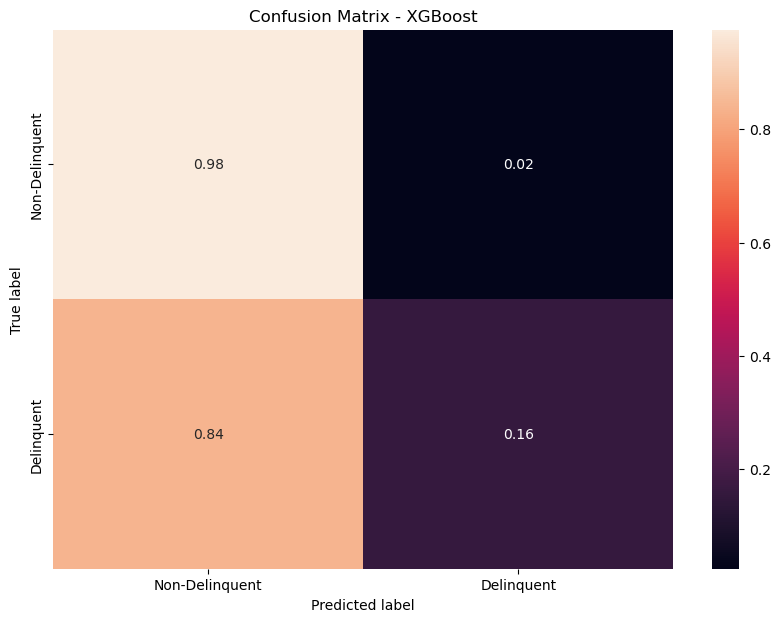

ROC AUC Score: 0.7860


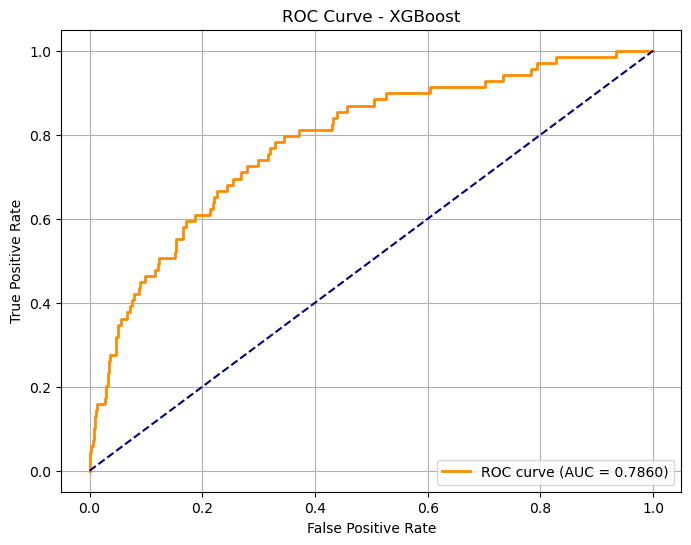

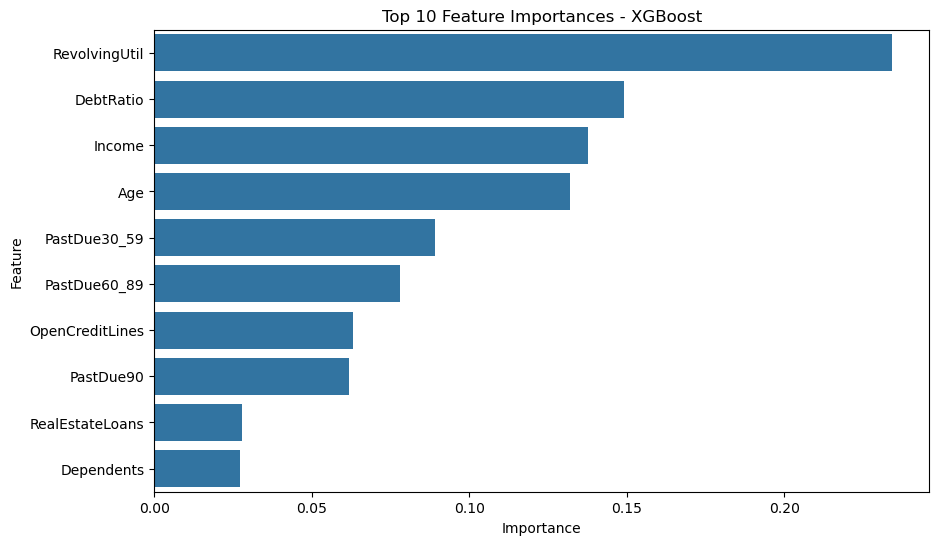


Classification Report XGBoost:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       944
           1       0.32      0.16      0.21        69

    accuracy                           0.92      1013
   macro avg       0.63      0.57      0.59      1013
weighted avg       0.90      0.92      0.91      1013



In [28]:
# ----------------------------
# 3: XGBoost Model with ORI Start
# ----------------------------

# ----------------------------
# STEP 1: Data Preparation
# ----------------------------

# Define features (X) and target (y) for training and testing
X_train_xgb = train_ori.drop(columns='Delinquent')   # Drop the target column to create training features
y_train_xgb = train_ori['Delinquent']                # Define training target

X_test_xgb = test_ori.drop(columns='Delinquent')     # Drop the target column to create test features
y_test_xgb = test_ori['Delinquent']                  # Define test target

# ----------------------------
# STEP 2: Model Training
# ----------------------------

# Initialize the Gradient Boosting model with hyperparameters
Delinquent_xgb = GradientBoostingClassifier(
    loss='log_loss',              # Logistic loss for classification
    learning_rate=0.1,            # Learning rate shrinks the contribution of each tree
    n_estimators=1000,            # Number of boosting stages to perform
    subsample=0.632,              # Fraction of samples to be used for fitting each tree
    criterion='friedman_mse',     # Function to measure the quality of a split
    min_samples_split=2,          # Minimum samples required to split an internal node
    min_samples_leaf=1,           # Minimum samples required to be at a leaf node
    min_weight_fraction_leaf=0.0, # Minimum weighted fraction of the input samples at a leaf
    max_depth=3,                  # Maximum depth of each tree
    min_impurity_decrease=0.01,   # A node will be split if this split decreases impurity
    random_state=33245215,            # Seed for reproducibility
    max_features='sqrt',          # Number of features to consider when looking for the best split
    verbose=1,                    # Verbosity (prints progress)
    validation_fraction=0.3,      # Proportion of training data for early stopping
    n_iter_no_change=None,        # If not None, early stopping is enabled
    tol=0.0001                    # Tolerance for the early stopping
)

# Fit the model on the training data
Delinquent_xgb.fit(X_train_xgb, y_train_xgb)

# ----------------------------
# STEP 3: Model Evaluation
# ----------------------------

# Predict class labels on the test data
xgb_pred_class_test = Delinquent_xgb.predict(X_test_xgb)

# Predict class probabilities (used for ROC/AUC)
xgb_probs_test = Delinquent_xgb.predict_proba(X_test_xgb)

# --- Confusion Matrix ---

# Generate the confusion matrix
confusion_matrix_xgb = confusion_matrix(y_true=y_test_xgb, y_pred=xgb_pred_class_test)

# Normalize the confusion matrix (row-wise)
confusion_matrix_xgb = confusion_matrix_xgb.astype('float') / confusion_matrix_xgb.sum(axis=1)[:, np.newaxis]

# Convert to DataFrame with appropriate labels
df_cm = pd.DataFrame(confusion_matrix_xgb, index=['Non-Delinquent', 'Delinquent'], columns=['Non-Delinquent', 'Delinquent'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - XGBoost')
plt.show()


# --- ROC AUC Score ---

# Use the probability of the positive class (index 1)
roc_auc = roc_auc_score(test_ori['Delinquent'], xgb_probs_test[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(test_ori['Delinquent'], xgb_probs_test[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Feature Importances ---

# Extract feature importances from the model
importances = Delinquent_xgb.feature_importances_
features = X_train_xgb.columns

# Create a DataFrame for the feature importances
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the features by importance
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot top 10 important features
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances - XGBoost')
plt.show()

# --- Classification Report ---

# Print classification performance metrics
print("\nClassification Report XGBoost:\n", classification_report(y_test_xgb, xgb_pred_class_test))


In [29]:
# -----------------------------
#   TASK 3
# -----------------------------

# -----------------------------
#   EMSR-A
# -----------------------------

# -----------------------------
# Input Parameters
# -----------------------------
capacity = 500  # Total room capacity

# Base Prices
price_premier_base = 999
price_advanced_base = 199
price_basic = 49  # Economy

# Demand Distributions
shape_premier = 50
scale_premier = 1500
fp_premier = stats.gamma(a=shape_premier, scale=scale_premier)

shape_advanced = 100
scale_advanced = 500
fp_advanced = stats.gamma(a=shape_advanced, scale=scale_advanced)

# -----------------------------
# Function to Calculate EMSR-A
# -----------------------------
def calc_protection(fp, p1, p2, guess=100):
    def flittle(y):
        return 1 - fp.cdf(y) - p2 / p1
    solution = fsolve(flittle, guess)
    return min(solution[0], capacity)

# -----------------------------
# Base Protection Levels
# -----------------------------
base_prot_premier = calc_protection(fp_premier, price_premier_base, price_advanced_base)
base_prot_advanced = calc_protection(fp_advanced, price_advanced_base, price_basic)

# -----------------------------
# +17% Price Scenario
# -----------------------------
price_premier_up = price_premier_base * 1.17
price_advanced_up = price_advanced_base * 1.17

prot_premier_up = calc_protection(fp_premier, price_premier_up, price_advanced_up)
prot_advanced_up = calc_protection(fp_advanced, price_advanced_up, price_basic)

# -----------------------------
# -17% Price Scenario
# -----------------------------
price_premier_down = price_premier_base * 0.83
price_advanced_down = price_advanced_base * 0.83

prot_premier_down = calc_protection(fp_premier, price_premier_down, price_advanced_down)
prot_advanced_down = calc_protection(fp_advanced, price_advanced_down, price_basic)

# -----------------------------
# Print Results
# -----------------------------
print(f"\n🔹 Base EMSR-A Protection Levels:")
print(f"Premier: {round(base_prot_premier, 2)}")
print(f"Advanced: {round(base_prot_advanced, 2)}")

print(f"\n🔺 With 17% Price Increase:")
print(f"Premier: {round(prot_premier_up, 2)}")
print(f"Advanced: {round(prot_advanced_up, 2)}")

print(f"\n🔻 With 17% Price Decrease:")
print(f"Premier: {round(prot_premier_down, 2)}")
print(f"Advanced: {round(prot_advanced_down, 2)}") 


🔹 Base EMSR-A Protection Levels:
Premier: 100.0
Advanced: 100.0

🔺 With 17% Price Increase:
Premier: 100.0
Advanced: 100.0

🔻 With 17% Price Decrease:
Premier: 100.0
Advanced: 100.0


/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [30]:
# -----------------------------
#   EMSR-B
# -----------------------------

# -----------------------------
# Base Input
# -----------------------------
# Price, mean demand (mu), and variance (sigmasq)
p_base = [999, 199, 49]
mu = [50, 100, 345]
sigmasq = [1500, 500, 440]

# -----------------------------
# Function to Calculate EMSR-B
# -----------------------------
def calc_emsrb(p, mu, sigmasq):
    # Average between Premier & Advanced
    pavg = np.average(p[0:2], weights=mu[0:2])
    muavg = np.sum(mu[0:2])
    ssqavg = np.sum(sigmasq[0:2])

    # EMSR-B: Premier vs Advanced
    normal1 = stats.norm(loc=mu[0], scale=np.sqrt(sigmasq[0]))
    def flittle_premier(y):
        return 1 - normal1.cdf(y) - p[1] / p[0]
    sol_premier = fsolve(flittle_premier, 70)[0]

    # EMSR-B: Combined (Premier + Advanced) vs Economy
    normal2 = stats.norm(loc=muavg, scale=np.sqrt(ssqavg))
    def flittle_combined(y):
        return 1 - normal2.cdf(y) - p[2] / pavg
    sol_combined = fsolve(flittle_combined, 300)[0]

    return round(sol_premier, 2), round(sol_combined, 2)

# -----------------------------
# Calculate EMSR-B for Base, +17%, -17% Price Scenarios
# -----------------------------
p_up = [round(i * 1.17, 2) for i in p_base]
p_down = [round(i * 0.83, 2) for i in p_base]

base_result = calc_emsrb(p_base, mu, sigmasq)
up_result = calc_emsrb(p_up, mu, sigmasq)
down_result = calc_emsrb(p_down, mu, sigmasq)

# -----------------------------
# Print Results
# -----------------------------
print("\n🔹 Base EMSR-B Protection Levels:")
print("Premier:", base_result[0], "| Combined (Premier + Advanced):", base_result[1])

print("\n🔺 +17% Price EMSR-B Protection Levels:")
print("Premier:", up_result[0], "| Combined (Premier + Advanced):", up_result[1])

print("\n🔻 -17% Price EMSR-B Protection Levels:")
print("Premier:", down_result[0], "| Combined (Premier + Advanced):", down_result[1])



🔹 Base EMSR-B Protection Levels:
Premier: 82.71 | Combined (Premier + Advanced): 206.01

🔺 +17% Price EMSR-B Protection Levels:
Premier: 82.71 | Combined (Premier + Advanced): 206.01

🔻 -17% Price EMSR-B Protection Levels:
Premier: 82.71 | Combined (Premier + Advanced): 206.01
